In [1]:
#Modules needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import random
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import  StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor



In [ ]:
#Import dataset 
train_x= pd.read_csv("/kaggle/input/playground-series-s5e3/train.csv").set_index('id')
test_x= pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv").set_index('id')
test_y= pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")
#test_x = pd.read_csv('test.csv').set_index('id')
#train_x = pd.read_csv('train.csv').set_index('id')
#test_y = pd.read_csv('sample_submission.csv').set_index('id')
y_train = train_x['rainfall']
train_x = train_x.drop(["rainfall"],axis="columns")
train_x.head()


,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
id,,,,,,,,,,,
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8
...,...,...,...,...,...,...,...,...,...,...,...
2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,22.1
2186,362,1012.4,17.2,17.3,16.3,15.3,91.0,88.0,0.0,50.0,35.3
2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,32.9


In [3]:
train_x.describe()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,179.948402,1013.602146,26.365799,23.953059,22.170091,20.454566,82.036530,75.721918,3.744429,104.863151,21.804703
std,105.203592,5.655366,5.654330,5.222410,5.059120,5.288406,7.800654,18.026498,3.626327,80.002416,9.898659
min,1.000000,999.000000,10.400000,7.400000,4.000000,-0.300000,39.000000,2.000000,0.000000,10.000000,4.400000
25%,89.000000,1008.600000,21.300000,19.300000,17.700000,16.800000,77.000000,69.000000,0.400000,40.000000,14.125000
50%,178.500000,1013.000000,27.800000,25.500000,23.850000,22.150000,82.000000,83.000000,2.400000,70.000000,20.500000
75%,270.000000,1017.775000,31.200000,28.400000,26.400000,25.000000,88.000000,88.000000,6.800000,200.000000,27.900000
max,365.000000,1034.600000,36.000000,31.500000,29.800000,26.700000,98.000000,100.000000,12.100000,300.000000,59.500000


In [4]:
#Scale train and test datasets
scaler = StandardScaler()
train_x_scaled = pd.DataFrame(scaler.fit_transform(train_x), columns=train_x.columns)
test_x_scaled = pd.DataFrame(scaler.transform(test_x), columns=test_x.columns)

test_x_scaled.describe()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,729.000000,730.000000
mean,0.029013,-0.017533,0.001179,0.001959,-0.011826,0.001054,0.081208,0.035420,-0.022079,-0.011752,0.068666
std,1.002460,0.973788,1.003446,1.010894,1.022297,1.019665,1.002544,0.995103,1.003799,1.021396,1.005899
min,-1.701361,-2.405725,-3.354974,-3.457634,-3.552830,-3.868696,-5.518302,-4.201549,-1.032804,-1.186024,-1.748586
25%,-0.836174,-0.862590,-0.843051,-0.790632,-0.859059,-0.691210,-0.613746,-0.372976,-0.943161,-0.810950,-0.738117
50%,0.029013,-0.159557,0.253704,0.325009,0.342017,0.349038,-0.004684,0.403836,-0.425991,-0.435876,-0.050999
75%,0.894200,0.707075,0.819772,0.846918,0.836287,0.859705,0.892882,0.681269,0.808322,1.189446,0.666434
max,1.759387,3.289284,1.668872,1.502895,1.370098,1.181237,2.046895,1.347107,2.221921,2.439694,3.808991


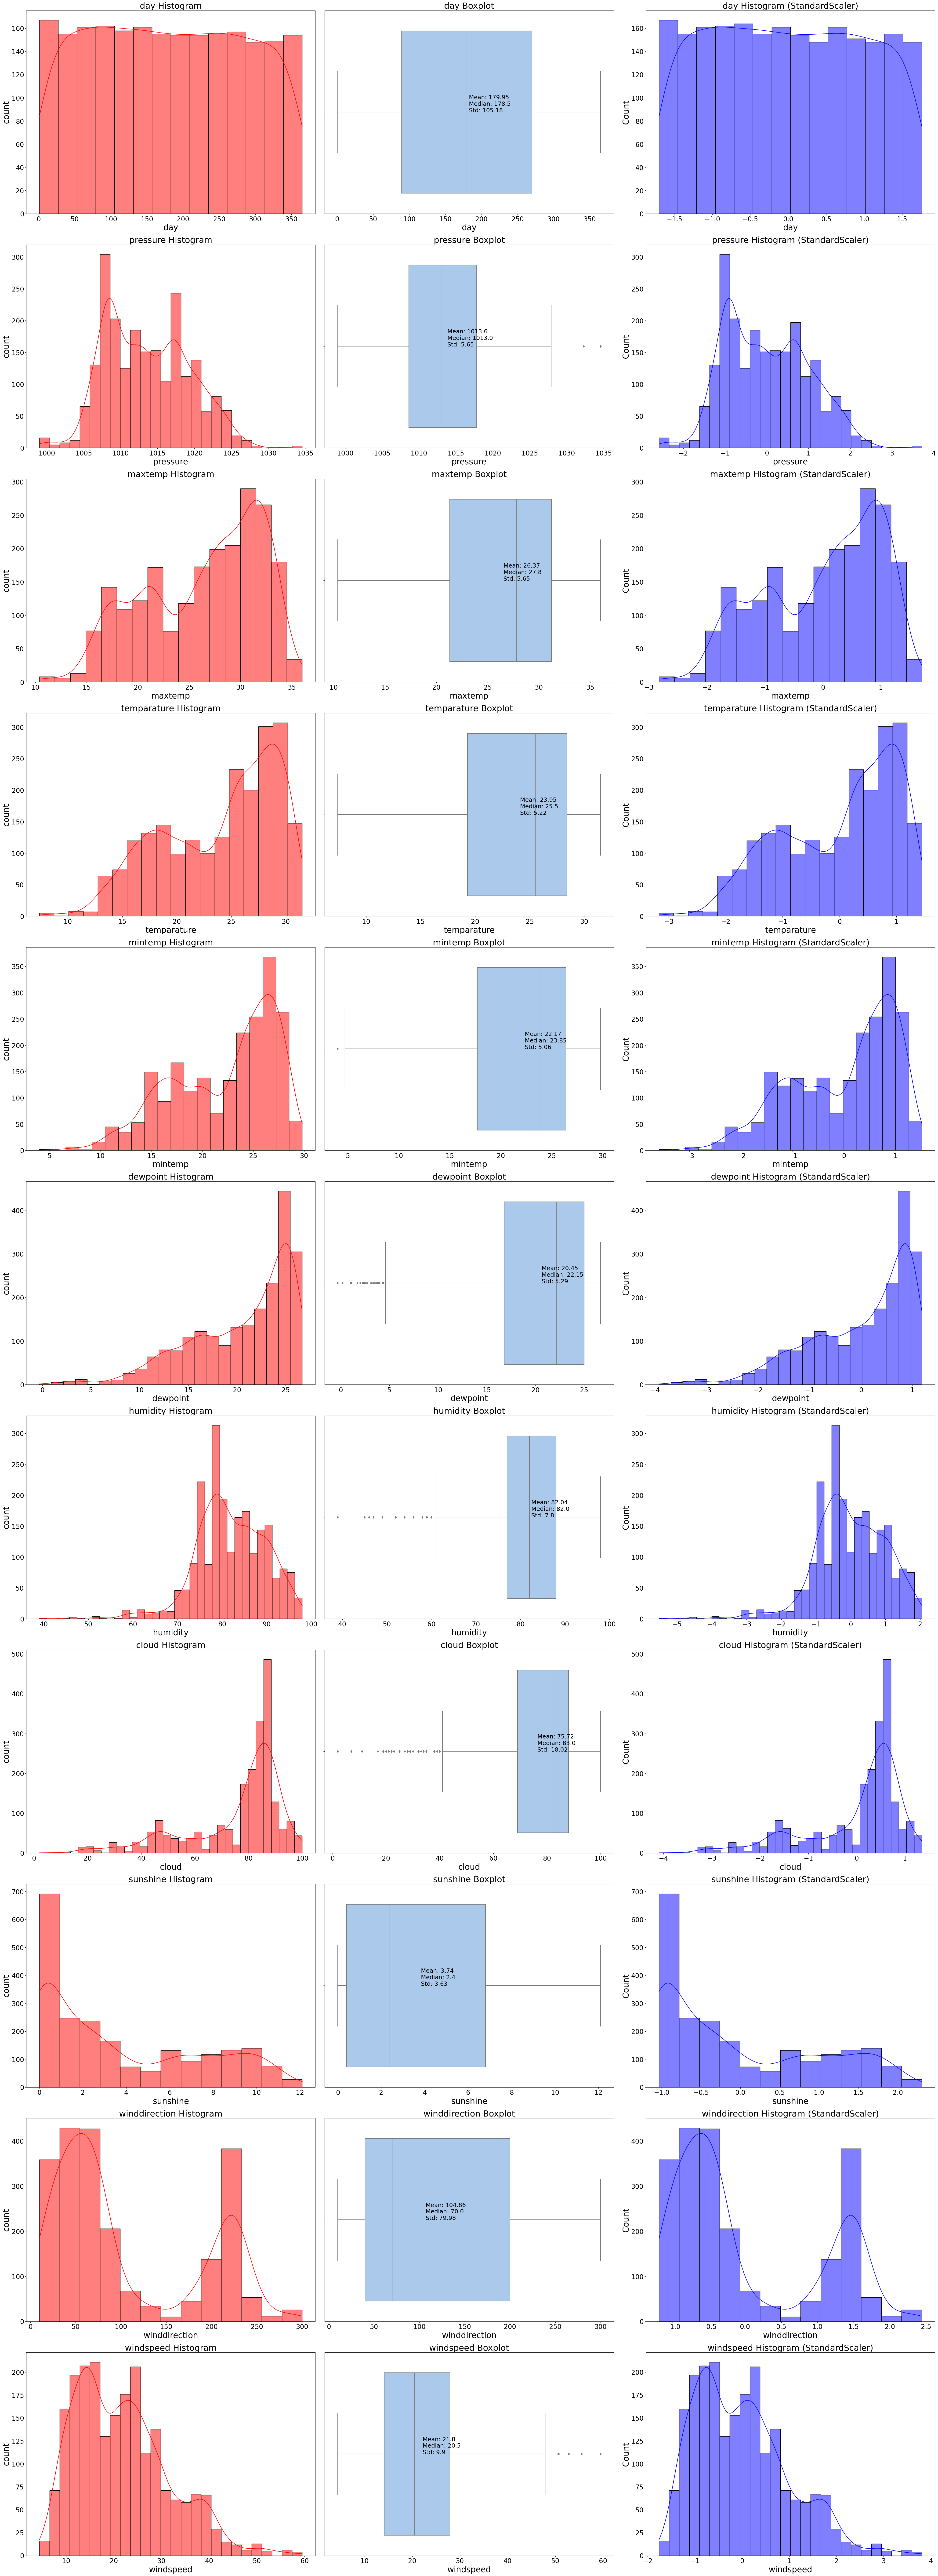

In [5]:
#Exploratory analysis on trainset
palettes = ["deep",  "pastel"]
palettes1 = ["red","blue"]
fig, axes = plt.subplots(len(train_x.columns),3,figsize=(40,10*len(train_x.columns)), constrained_layout = True)
for axs, xy in zip(axes,train_x.columns):
    sns.histplot(train_x[xy], ax=axs[0], color=palettes1[0], kde=True)
    axs[0].set_title(f"{xy} Histogram", fontsize=26)
    axs[0].set_xlabel(xy,fontsize=25)
    axs[0].set_ylabel("count" ,fontsize=25)
    axs[0].tick_params(axis='both', labelsize=20)
    
    #axs.set_ylabel("Rainfall")
    sns.boxplot(data= train_x, x=xy, ax=axs[1], palette=palettes[1], orient="h" )
    axs[1].set_title(f"{xy} Boxplot", fontsize=26)
    axs[1].set_xlabel(xy,fontsize=25)
    axs[1].tick_params(axis='both', labelsize=20)
    axs[1].annotate(f"\n Mean: {round(np.mean(train_x[xy]),2)} \n Median: {round(np.median(train_x[xy]),2)} \n Std: {round(np.std(train_x[xy]),2)}",
                    xy=(np.mean(train_x[xy]),(train_x[xy] == np.mean(train_x[xy])).sum()), fontsize=18
    )

    # Define percentiles
    #lower_bound, upper_bound = np.percentile(train_x[xy], [2.5, 97.5])
    #filtered_data = train_x[xy][(train_x[xy] >= lower_bound) & (train_x[xy] <= upper_bound)]

    # Plot histogram with filtered data
    sns.histplot(train_x_scaled[xy], ax=axs[2], color=palettes1[1], kde=True)
    axs[2].set_title(f"{xy} Histogram (StandardScaler)", fontsize=26)
    axs[2].set_xlabel(xy, fontsize=25)
    axs[2].set_ylabel("Count", fontsize=25)
    axs[2].tick_params(axis='both', labelsize=20)

    




<Axes: >

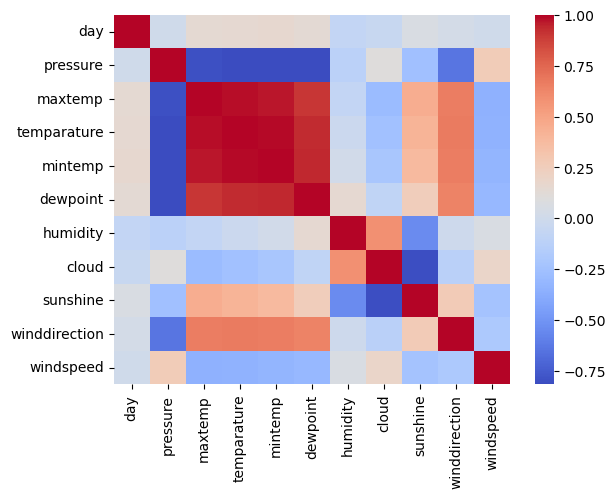

In [65]:
sns.set_palette(random.choice(palettes))
sns.heatmap(train_x.corr(), cmap="coolwarm")


In [12]:
# Select only the temperature-related features as had high correlation values among each other
X = train_x[["mintemp", "temparature", "maxtemp"]]

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

       Feature          VIF
0      mintemp   791.581831
1  temparature  1744.569746
2      maxtemp   675.890139


In [7]:
# Defining our datasets
X_train_scaled = train_x_scaled



In [8]:
# Test set count for winddirection and windspeed vary from other. Treating missing values
test_x.fillna(np.mean(test_x), inplace=True)
test_x.describe()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,183.000000,1013.503014,26.372466,23.963288,22.110274,20.460137,82.669863,76.360274,3.664384,103.977405,22.484247
std,105.438271,5.505871,5.672521,5.278098,5.170744,5.391169,7.818714,17.934121,3.639272,81.652551,9.954779
min,1.000000,1000.000000,7.400000,5.900000,4.200000,-0.000000,39.000000,0.000000,0.000000,10.000000,4.500000
25%,92.000000,1008.725000,21.600000,19.825000,17.825000,16.800000,77.250000,69.000000,0.325000,40.000000,14.500000
50%,183.000000,1012.700000,27.800000,25.650000,23.900000,22.300000,82.000000,83.000000,2.200000,70.000000,21.300000
75%,274.000000,1017.600000,31.000000,28.375000,26.400000,25.000000,89.000000,88.000000,6.675000,200.000000,28.400000
max,365.000000,1032.200000,35.800000,31.800000,29.100000,26.700000,98.000000,100.000000,11.800000,300.000000,59.500000


Best Test Accuracy: 0.8699
Best XGB Parameters: n_estimators=50, learning_rate=0.085, max_depth=3, subsample=0.75, colsample_bytree=0.675
[0.978312   0.9749956  0.9335785  0.13958704 0.07940889 0.8427824
 0.9331283  0.97473747 0.9603203  0.84818166 0.97395295 0.10564113
 0.97486854 0.9630884  0.1678699  0.05108515 0.94132507 0.7562406
 0.08770244 0.04517309 0.093363   0.14910918 0.74392736 0.9747459
 0.88680136 0.3704133  0.07913511 0.9747459  0.92069966 0.3952907
 0.9586256  0.9507637  0.8670093  0.97173786 0.85231364 0.9597449
 0.3164226  0.9225856  0.85199887 0.8961688  0.85152787 0.87969244
 0.09403033 0.915387   0.96247494 0.19513097 0.20551632 0.97394425
 0.13928351 0.83881366 0.95851356 0.9747459  0.9726069  0.96570444
 0.9747459  0.9740815  0.9635554  0.9222866  0.9477313  0.9681549
 0.92357373 0.9726069  0.96602184 0.8497622  0.27690175 0.16727218
 0.09388658 0.8723829  0.8526988  0.07743724 0.9747459  0.93020964
 0.9315592  0.9656104  0.97395295 0.96540135 0.91964036 0.970677

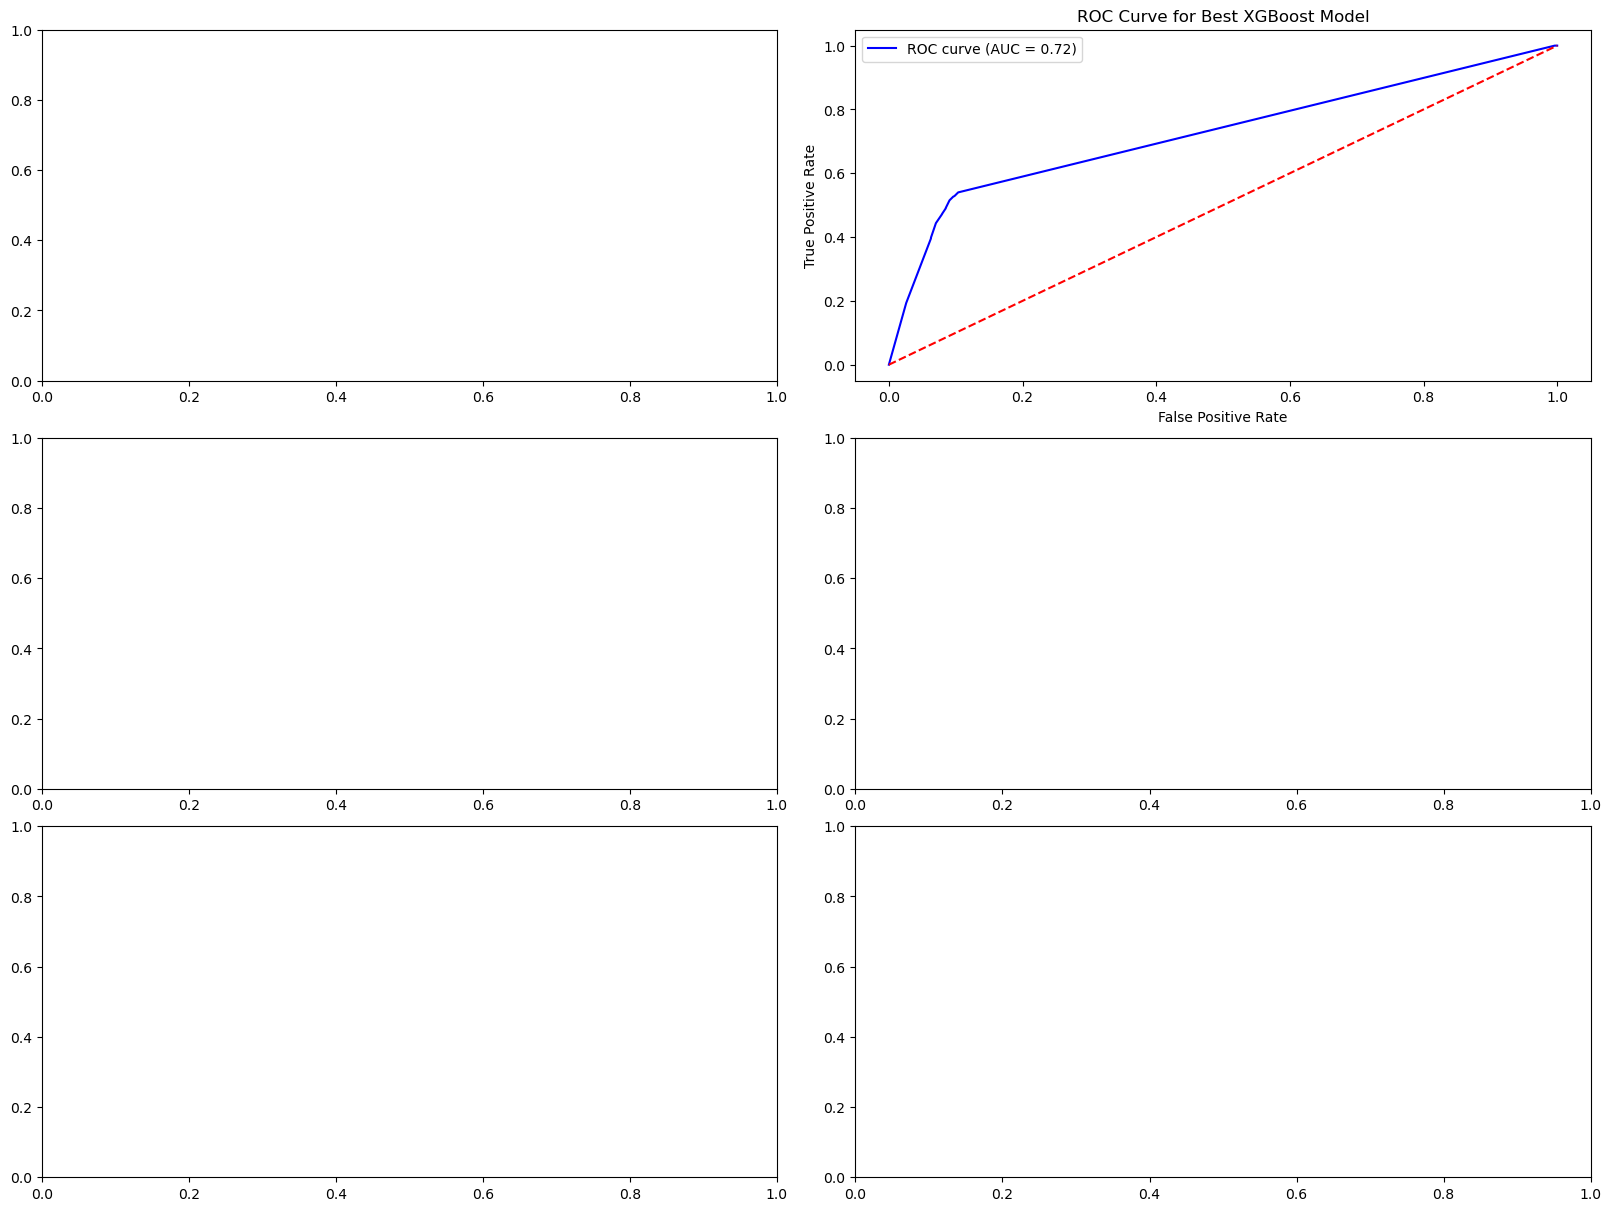

In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold , train_test_split
import matplotlib.pyplot as plt

# Define models
tree_models = ["gbtree", GradientBoostingClassifier, RandomForestClassifier]
fig, axes = plt.subplots(len(tree_models), 2, figsize=(16, 4 * len(tree_models)), constrained_layout=True)
xgboost_settings = np.arange(100, 702, 100)
forest_settings = np.arange(100, 1002, 50)
settings = [xgboost_settings, forest_settings, forest_settings]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=22)
prob = {}
best_models = {}

X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42
)

# **Step 1: Define 5 XGBoost parameter combinations using zip**
param_grid_xgb = list(zip(
    # n_estimators (more trees require lower learning rate)
    [50,75,100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000],
    
    # learning_rate (decreases as n_estimators increases)
    [0.085,0.9, 0.08, 0.07, 0.06, 0.05, 0.045, 0.04, 0.035, 0.03, 0.025, 0.02, 0.015, 0.01, 0.008, 0.005],

    # max_depth (deeper trees capture more complexity but risk overfitting)
    [3,3, 4, 5, 6, 7, 8, 9, 10, 11],

    # subsample (reduces overfitting, should be between 0.6-1.0)
    [0.75,0.8, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0],

    # colsample_bytree (number of features considered per tree)
    [0.675, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
))

for axs, rant, settings in zip(axes, tree_models, settings):

    if rant == "gbtree":
        test_accuracies = []
        xgb_models = []

        # **Step 2: Train 5 fixed XGBoost models with different parameters**
        for n_est, lr, max_d, sub_s, col_s in param_grid_xgb:
            clf = xgb.XGBClassifier(
                booster=rant,
                n_estimators=n_est,
                learning_rate=lr,
                max_depth=max_d,
                subsample=sub_s,
                colsample_bytree=col_s,
                objective="binary:logistic",
                random_state=42,
                use_label_encoder=False
            )

            # Train & predict
            clf.fit(X_train_sub, y_train_sub) #y_train_sub, y_val
            y_pred = clf.predict(X_val)
            y_scores = clf.predict_proba(X_val)[:, 1]
            #y_pred = (y_scores >= 0.5).astype(int) 
            test_acc = accuracy_score(y_val, y_pred)

            test_accuracies.append((clf, test_acc, n_est, lr, max_d, sub_s, col_s))
            xgb_models.append(clf)

        # **Step 3: Select the best model based on test accuracy**
        best_model, best_test_acc, best_n_est, best_lr, best_max_d, best_sub_s, best_col_s = max(test_accuracies, key=lambda x: x[1])
        print(f"Best Test Accuracy: {best_test_acc:.4f}")
        print(f"Best XGB Parameters: n_estimators={best_n_est}, learning_rate={best_lr}, max_depth={best_max_d}, subsample={best_sub_s}, colsample_bytree={best_col_s}")

        best_models["gbtree"] = best_model
        best_model.fit(X_train_scaled, y_train)
        y_pred = best_model.predict_proba(test_x_scaled)[:,1]
        

        # **Step 4: Compute ROC Curve for the best test-performing model**
        best_y_scores = best_model.predict_proba(train_x)[:, 1]
        fpr, tpr, _ = roc_curve(y_train, best_y_scores)
        roc_auc = auc(fpr, tpr)

        # Plot ROC Curve
        axs[1].plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
        axs[1].plot([0, 1], [0, 1], color="red", linestyle="--")
        axs[1].set_xlabel("False Positive Rate")
        axs[1].set_ylabel("True Positive Rate")
        axs[1].set_title(f"ROC Curve for Best XGBoost Model")
        axs[1].legend()



In [56]:
best_y_scores.shape

(2190,)

In [64]:
best_models1 = max(best_models, key=best_models.get)
print(str(best_models1).split("'")[0])
prob_r = pd.DataFrame({"id":test_x.index,
                       "Rainfall Prob":y_pred}
                      )

prob_r.to_csv('submission.csv', index=False)
prob_r.head()

gbtree


,id,Rainfall Prob
0,2190,0.978312
1,2191,0.974996
2,2192,0.933578
3,2193,0.139587
4,2194,0.079409
